# Section 4.1 : CYCLICAL LEARNING RATES
## Summary
- Need to tune learning rate, momentum, and weight decay (L2) to get best performance
- Grid search is time consuming, but hyper parameters are tightly coupled to each other
- Too smaller a LR = overfitting, too large a LR = divergence therefore pick LR using LR range-test
- LR can then be adjusted using [cyclical learning-rates](https://arxiv.org/abs/1506.01186) (CLR)
- Large learning rates are a form of regularisation, and can lead to super-convergence
- The amount of regularisation must be balanced for each dataset and architecture, e.g. super convergence only possible if other forms of regularisation are reduced

## Cyclical Learning-Rate Example
- CLR means varying the learning rate after each minibatch between two boundaries: the optimum (as found by LRFinder), and a minimum value about 3-4 times lower than the maximum
- The simplest method is to vary the LR linearly between the bounds
- CLR helps to mitigate the risk of networks diverging at high LRs, i.e. it allows one to benefit more from the reduced underfitting of high LRs with a reduced risk of divergence
- There is a maximum rate at which the LR can be varied, before the network becomes unstable, therefore adjust the step size

Let's take the same model and train three different times:

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data, features = importData()

Training on 250000 datapoints with 31 features:
['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


In [3]:
preprocParams = {'normIn':True, 'pca':False}
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'sgd', 'depth':3, 'width':128}
trainParams = {'epochs':30, 'batch_size':256, 'verbose':0}

In [4]:
trainIndeces, valIndeces = train_test_split([i for i in data.index.tolist()], test_size=0.2)
train, val = foldPrep(data.iloc[trainIndeces], data.iloc[valIndeces], features, preprocParams)

Epoch 1/1
193024/200000 [===========================>..] - ETA: 0s - loss: 5.7147e-06
______________________________________
Training finished
LR finder took 2.383s 


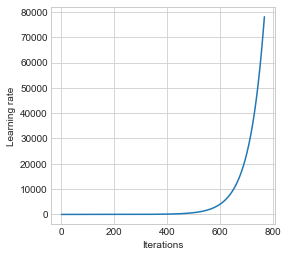

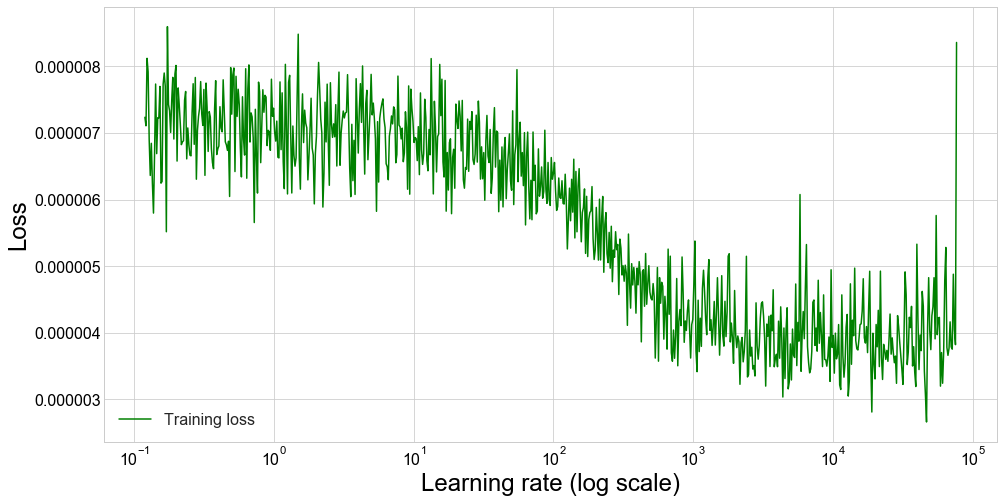

______________________________________



In [5]:
lrFinder = runLRFinder(data, features, {'version':'modelRelu', 'nIn':len(features), 'compileArgs':compileArgs}, trainParams, preprocParams, useValidation=0, lrBounds=[1e-1, 1e5]) 

In [6]:
model1Params = {'version':'modelRelu', 'nIn':len(features), 'compileArgs':{**compileArgs, 'lr':5e3}}
model2Params = {'version':'modelRelu', 'nIn':len(features), 'compileArgs':{**compileArgs, 'lr':5e2}}
model3Params = {'version':'modelRelu', 'nIn':len(features), 'compileArgs':{**compileArgs, 'lr':1e4}}

Using a large LR

In [14]:
model1, history1, _ = trainClassifier(getModel(**model1Params), train, val, trainParams, useEarlyStop=False)

Using an optimum LR

In [8]:
model2, history2, _ = trainClassifier(getModel(**model2Params), train, val, trainParams, useEarlyStop=False)

Using the large LR, but with CLR

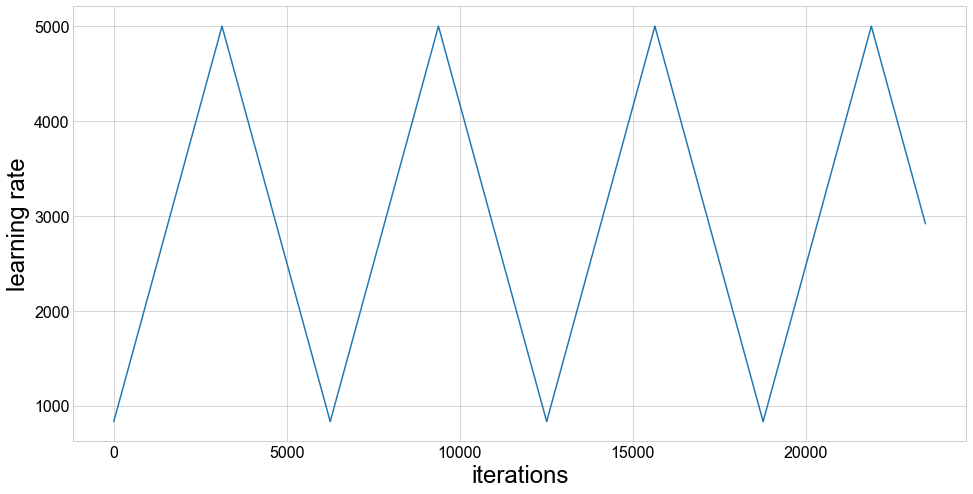

In [12]:
lrScale=6
stepScale=4
model1CLR, history1CLR, _ = trainClassifier(getModel(**model1Params), train, val, trainParams, useEarlyStop=False,
                                            useCallbacks={'LinearCLR':{'maxLR':model1Params['compileArgs']['lr'],
                                                                       'minLR':model1Params['compileArgs']['lr']/lrScale,
                                                                       'scale':stepScale, 'plotLR':True}})

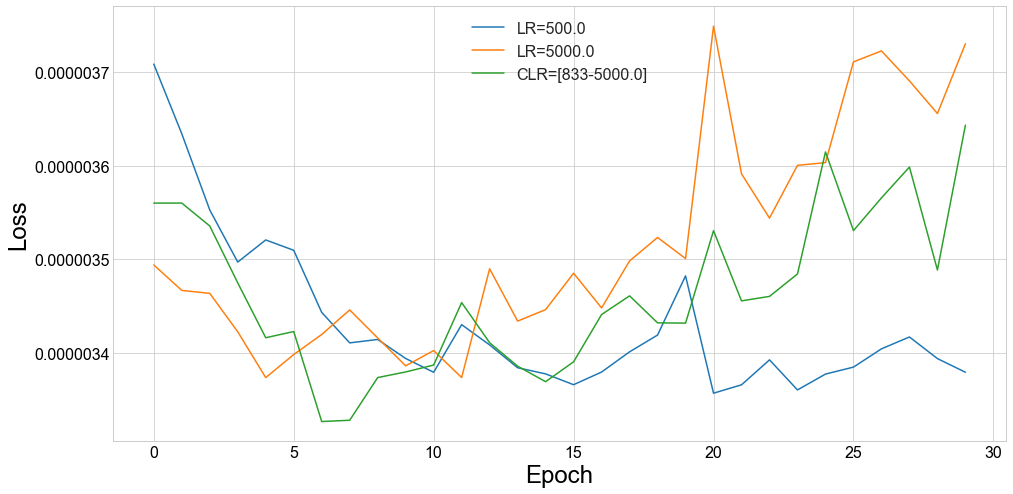

In [15]:
getModelHistoryComparisonPlot([history2, history1, history1CLR], ['LR={}'.format(model2Params['compileArgs']['lr']),
                                                                  'LR={}'.format(model1Params['compileArgs']['lr']),
                                                                  'CLR=[{:.0f}-{}]'.format(model1Params['compileArgs']['lr']/lrScale,
                                                                                           model1Params['compileArgs']['lr'])])

Here we see that using a large, constant learning-rate (<span style="color:orange">orange</span>) exhibits instability, quickly leads to divergence, and never beats out the optimal learning-rate (<span style="color:blue">blue</span>)

Instead by cycling between a smaller LR and the large one (<span style="color:green">green</span>), we are able to converge very quickly (~6 epochs), to a better loss than the constant, optimum LR. Although the CLR does display a bit of instability, so further parameter tuning might be needed.

### Cosine Annealing with restarts
While not mentioned in the paper, we can instead anneal the LR according to a cosine function, and then jumping up to the maximum LR at 0. Decaying the learning rate, allows one to make use of large initial learning-rates for quick convergence, and smaller learning-rates to arrive at the minima.
Additionally, the discrete changes at lr=0, may be used to jump out of narrow minima (which have poor generalisation) to eventually arrive in wider minima (better generalisation). They can even be used to build an ensemble from a single training, via [snapshot ensembling](https://arxiv.org/abs/1704.00109). The Fast.AI course also gives a good explanation of these points [here](https://youtu.be/JNxcznsrRb8?t=30m33s)

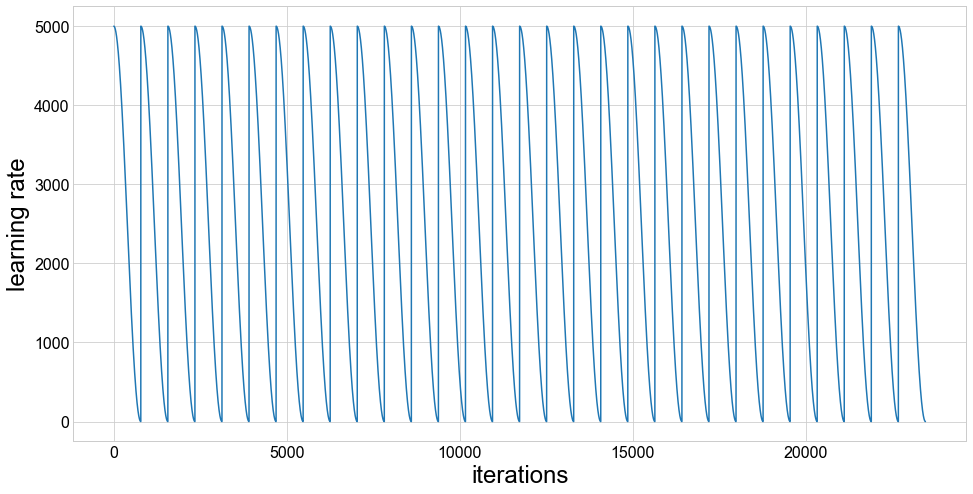

In [16]:
model1Cos, history1Cos, _ = trainClassifier(getModel(**model1Params), train, val, trainParams, useEarlyStop=False,
                                            useCallbacks={'CosAnnealLR':{'plotLR':True}})

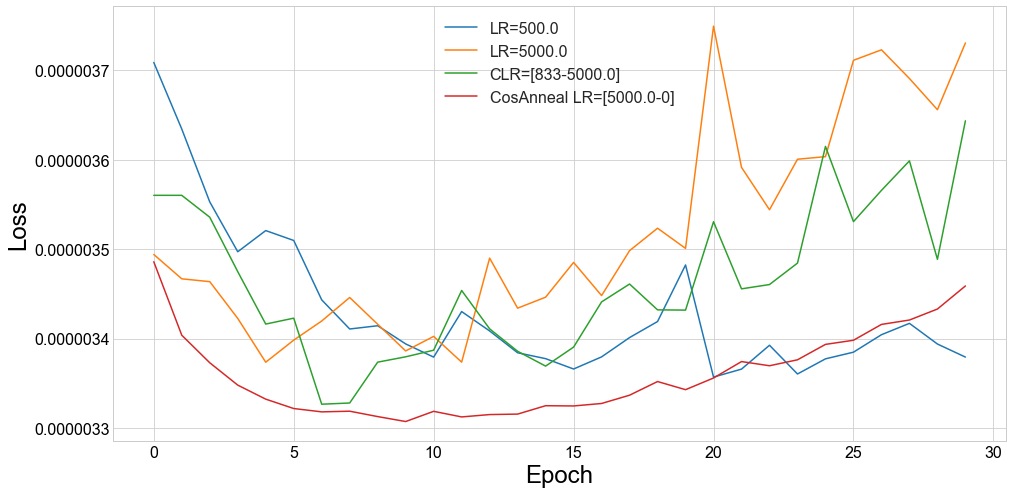

In [17]:
getModelHistoryComparisonPlot([history2, history1, history1CLR, history1Cos],
                              ['LR={}'.format(model2Params['compileArgs']['lr']),
                               'LR={}'.format(model1Params['compileArgs']['lr']),
                               'CLR=[{:.0f}-{}]'.format(model1Params['compileArgs']['lr']/lrScale,
                                                        model1Params['compileArgs']['lr']),
                               'CosAnneal LR=[{}-0]'.format(model1Params['compileArgs']['lr'])])

Using cosine annealing with restarts (<span style="color:red">red</span>), we're able to reach a slightly better loss than the linear cycle performance (<span style="color:green">green</span>), in about the same time. However, the validation loss is much more stable (smoother line), which perhaps indicates that it is able to more easily find wider minima.

We can even adjust the `cycle_mult` parameter to cause the cycle length to double or triple after each cycle, to make it easier to coverge to the centres of the wider minima.

### Super convergence

Section 4.1 then goes on to mention _super convergence_, in which a single LR cycle (with momentum also evolving in the opposite direction) is used to reach optimum performanace about 8 times quicker. I have tried to get this to work, but so far have been without success. Possibly the architecture and problem are too simple here (the paper uses deep resnets on cifar-10).

It could also be that CLR is already exhibiting super-convergence (it reaches it's minimum much quicker than a constant LR), and so using the specifically designed super-convergence policy does not offer any benefit here.

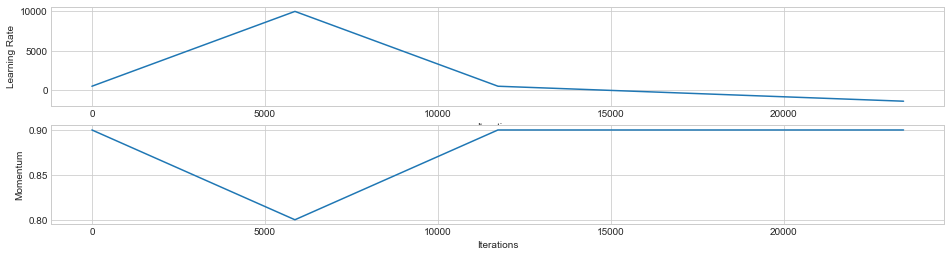

In [18]:
model3One, history3One, _ = trainClassifier(getModel(**model3Params), train, val, trainParams, useEarlyStop=False,
                                            useCallbacks={'OneCycle':{'scale':15, 'lrScale':20, 'momScale':0.1, 'plot':True}})

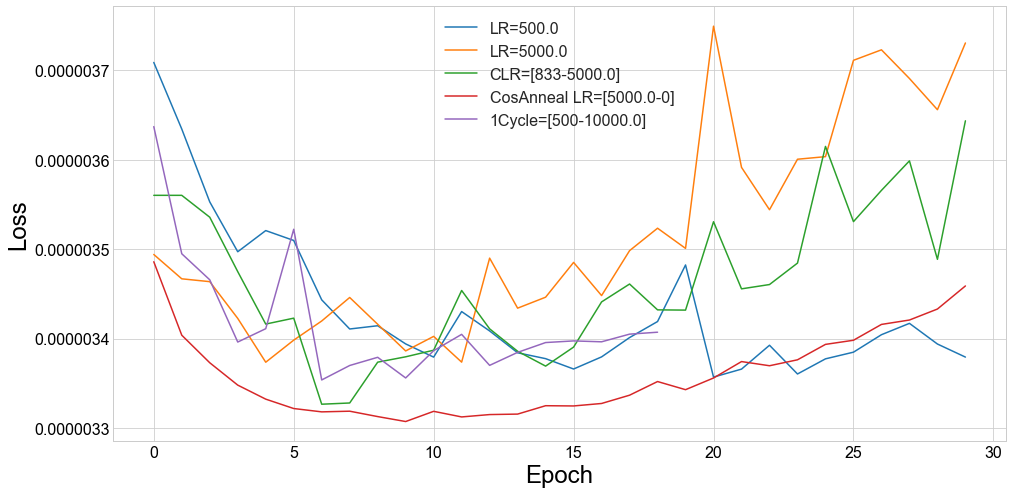

In [21]:
getModelHistoryComparisonPlot([history2, history1, history1CLR, history1Cos, {'val_loss':history3One['val_loss'][:-11]}],
                              ['LR={}'.format(model2Params['compileArgs']['lr']),
                               'LR={}'.format(model1Params['compileArgs']['lr']),
                               'CLR=[{:.0f}-{}]'.format(model1Params['compileArgs']['lr']/lrScale,
                                                        model1Params['compileArgs']['lr']),
                               'CosAnneal LR=[{}-0]'.format(model1Params['compileArgs']['lr']),
                               '1Cycle=[{:.0f}-{}]'.format(model3Params['compileArgs']['lr']/20,
                                                           model3Params['compileArgs']['lr'])])

Using 1cycle scheduling (<span style="color:purple">purple</span>), we get a similar trend to the CLR loss (<span style="color:green">green</span>), but it is more unstable, and performs worse. There are several hyperparameters to tune for it, but I think that CLR is already displaying super-convergence, so 1cycle is unlikely to offer much benefit for this architecture and dataset.